<img src="https://i.ibb.co/NjSZDm5/kolkata-skyline-in-watercolor-background-pablo-romero.jpg" alt="kolkata"
	title="Kolkata" width = 1000/>

# Capstone Project - Kolkata - (The City of Joy) Restaurant Business Analysis 
### Applied Data Science Capstone by IBM/Coursera
### By Victor Banerjee


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In the project I tried to find an optimal location for a restaurant. The stakeholders is very new in the restaurant business so they are totally depends on my analysis to find a **optimal location**  to start new restaurant chain business.  

As **Kolkata,IN** is one of the four major cities in India the most part of the **Kolkata,IN** is crowded with multiple restaurants. As it is a 300 year old cities lots of types cuisine restaurant are predominant in Kolkata. My goal is to **provide few optimal options to the stakeholders to run a profitable business restaurant**.
I will try to find the optimal place with with following criteria :

    1. Less crowded with popular restaurants.
    2. Customer Rating Of the restaurant
    3. Possible cuisine for the restaurant
    4. Highly popular place in Kolkata 

In the final step I will try to find few promising areas in Kolkata meet the stakeholders criteria. Using **E**xploratory **D**ata **A**nalysis with provide summary of Kolkata restaurant business paradigm.

# Data <a name="data"></a>

By understanding our current business problem I have outline few factors that the decisions are:
* Popularity of the Place in Kolkata and distance from it
* Numbers of and distance to the Popular restaurant are in the neighborhood
* What types and kinds of cuisines available in the Kolkata restaurants
* Customers sentiments on restaurant business

To resolve the business problem following datasets are needed to extract/ generate data to summarize our prospective:
- Kolkata's pin codes Coordinates are extract from Google Search Page by BeutifulSoup Library
- FourSquare Api is used to generate neighborhood datasets
- Zomato Api is used to generate restaurants details datasets
- Zomato Api is used for generating Customers reviews datasets

Python Library Used
~~~
from bs4 import BeautifulSoup #Web Scrapping
import numpy as np
from tabulate import tabulate
import json #library for Json file
from geopy.geocoders import Nominatim # Convert an address into latitude and longitude values
import folium # Map rendering library
~~~


## Methodology <a name="methodology"></a>

- I have used **BeautifulSoup** Kolkata's pincodes Coordinates scrap data from Google search page.
- There are no python codes available for extracting Zomato restaurants details, for I have created a **Object class for python to request Zomato Api**. 
- Data cleaning and EDA is done using Python Pandas and Numpy Library
- Folium Map used for displaying spatial location of the restaurants.
- NLP used for Review sentiment analysis

# Zomato API request

In [1]:
# Zomato web acesss
class Zomato:
    def __init__(self, user_key, content_type = 'application/json'):
        self._key = user_key
        self.request_count = 0
        self.content_type = content_type
        self._header = {
                    'Accept': content_type,
                    'user-key': user_key,
                            }
        self._categories_id = {}

    def get_response(self,api,params=''):
        import requests
        headers = self._header
        status = {  200 :'Sucessfully Connected to Zomato..',
                    403 :'Connection Error: Invalid User Keys',
                    404 : 'No Connection to Server..'
                }
        response = requests.get(api, headers=headers,params=params)
        print(status[response.status_code])
        if response.status_code == 200:
            self.request_count += 1
            return response.json()
    
    def categories(self,method='get'):
        api = 'https://developers.zomato.com/api/v2.1/categories'
        response = self.get_response(api)
        result_dict = {categories['categories']['name']: categories['categories']['id'] for categories in response['categories']}
        if method == 'set':
            self._categories_id = result_dict 
        return result_dict
    
    def cities(self,city_name='',id='',lat='',lon=''):
        params = (
            ('q', city_name),
            ('lat', lat),
            ('lon', lon),
            ('city_ids', id))

        api = 'https://developers.zomato.com/api/v2.1/cities'
        response = self.get_response(api,params=params)  
        return response

    def cuisines(self,city_id='',lat='',lon=''):
        params = (
            ('city_id', city_id),
            ('lat', lat),
            ('lon', lon))
        api = 'https://developers.zomato.com/api/v2.1/cuisines'
        response = self.get_response(api,params=params)  
        return response
    
    def geocode(self,lat='',lon=''):
        api = 'https://developers.zomato.com/api/v2.1/geocode'
        params = (
            ('lat', lat),
            ('lon', lon))
        response = self.get_response(api,params=params)  
        return response

    def location(self,city='',lat='',lon='',max_count=100):
        api = 'https://developers.zomato.com/api/v2.1/locations'
        params = (
        ('query', city),
        ('lat', lat),
        ('lon', lon),
        ('count', str(max_count)))
        response = self.get_response(api,params=params)  
        return response
    
    def location_details(self,city='',lat='',lon=''):
        r = self.location(city,lat,lon,1)
        entity_id = r['location_suggestions'][0]['entity_id']
        entity_type = r['location_suggestions'][0]['entity_type']

        params = (
            ('entity_id', entity_id),
            ('entity_type', entity_type))
        api = 'https://developers.zomato.com/api/v2.1/location_details'

        response = self.get_response(api,params=params)  
        return response
    
    def restaurant(self,res_id=''):
        api = 'https://developers.zomato.com/api/v2.1/restaurant'
        params = (
                ('res_id', res_id),)
        response = self.get_response(api,params=params) 
        return response
    
    def reviews(self,res_id='',start='1',count='10'):
        api = 'https://developers.zomato.com/api/v2.1/reviews'
        params = (
            ('res_id', res_id),
            ('start', start),
            ('count', count),) 
        response = self.get_response(api,params=params) 
        return response

In [2]:
# Importing Python Library
import pandas as pd #library for Dataframe
import numpy as np # Array 
import json #library for json file
import folium # Map Rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [3]:
kolkata = pd.read_csv('kolkata_resturent.csv',index_col=0)

# Kolkata's Coordinates & geojson

address = 'Kolkata, IN'
kol_geojson = 'https://raw.githubusercontent.com/datameet/Municipal_Spatial_Data/master/Kolkata/kolkata.geojson'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of **{}** are {}, {}.'.format(address,latitude, longitude))

The geograpical coordinate of **Kolkata, IN** are 22.54541245, 88.3567751581234.


In [4]:
kolkata = pd.read_csv('kolkata_resturent.csv',index_col=0)
kolkata.head()

,pincode,latitude,longitude,location,subzone,top_cuisines,popularity,nearby_res
114,700122,22.766851,88.376411,Barrackpore,Barrackpore,"Chinese,North Indian,Fast Food,Bengali,Mughlai",4.17,"17983797,18311142,18698012,23973,18663023,2364..."
113,700121,22.766614,88.422983,Barrackpore,Barrackpore,"Chinese,North Indian,Fast Food,Bengali,Mughlai",4.17,"17983797,18311142,18698012,23973,18663023,2364..."
112,700120,22.752200,88.379000,Barrackpore,Barrackpore,"Chinese,North Indian,Fast Food,Bengali,Mughlai",4.17,"17983797,18311142,18698012,23973,18663023,2364..."
111,700119,22.734883,88.396685,Khardah,Khardah,"Chinese,North Indian,Fast Food,Biryani,Bengali",3.95,"19127565,24311,25341,19114341,18198698,1860263..."
109,700117,22.723511,88.375425,Khardah,Khardah,"Chinese,North Indian,Fast Food,Biryani,Bengali",3.95,"19127565,24311,25341,19114341,18198698,1860263..."


### Kolkata Popular restaurants Cluster
In this part **folium** library used to find the heatmap of Kolkata most Popular places. Next I have used subsets of areas where ratings is greater than 4.5 and calculates the distance pairwise matrix between then. Sklearn K-means Clustering used to find the clusters.


In [132]:
map_kolkata = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, pincode in zip(kolkata['latitude'], kolkata['longitude'],kolkata['pincode']):
    label = '{}'.format(pincode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kolkata)  
    
map_kolkata

In [14]:

def generateBaseMap(default_location=[latitude, longitude], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
def add_marker(dataframe,map_,color='blue'):
    for lat, lng, pincode,location in zip(dataframe['latitude'], dataframe['longitude'],dataframe['pincode'],dataframe['subzone']):
        label = '{}({})'.format(location,pincode)
        label = folium.Popup(label, parse_html=True)
        geo_data = kol_geojson
        folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.5,
        parse_html=False).add_to(map_)
    return map_


In [5]:
from folium.plugins import HeatMap

base_map = generateBaseMap()
#Add Heatmap by Rating
HeatMap(data=kolkata[['latitude', 'longitude', 'popularity']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=13, max_zoom=12).add_to(base_map)

kolkata_4 = kolkata[kolkata.popularity > 4.0]
kolkata_3to4 = kolkata[kolkata.popularity.between(3.0, 3.99, inclusive=True)]
kolkata_2to3 = kolkata[kolkata.popularity.between(2.0, 2.99, inclusive=True)]
kolkata_1to2 = kolkata[kolkata.popularity.between(1.0, 1.99, inclusive=True)]
kolkata_1 = kolkata[kolkata.popularity < 1.0]


# add markers to map
add_marker(kolkata_4,base_map,color='red')
add_marker(kolkata_3to4,base_map,color='orange')
add_marker(kolkata_2to3,base_map,color='yellow')
add_marker(kolkata_1,base_map,color='blue')
add_marker(kolkata_1to2,base_map,color='cyan')

#Display Map
#base_map

In [5]:
# Calculate distance from kolkata
import math

def distance(origin):
    lat1, lon1 = origin[0],origin[1]
    lat2, lon2 = latitude,longitude
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d
    

In [6]:
kolkata['distance'] = kolkata[['latitude','longitude']].apply(distance,axis=1)
kolkata.head()

,pincode,latitude,longitude,location,subzone,top_cuisines,popularity,nearby_res,distance
114,700122,22.766851,88.376411,Barrackpore,Barrackpore,"Chinese,North Indian,Fast Food,Bengali,Mughlai",4.17,"17983797,18311142,18698012,23973,18663023,2364...",24.705129
113,700121,22.766614,88.422983,Barrackpore,Barrackpore,"Chinese,North Indian,Fast Food,Bengali,Mughlai",4.17,"17983797,18311142,18698012,23973,18663023,2364...",25.517470
112,700120,22.752200,88.379000,Barrackpore,Barrackpore,"Chinese,North Indian,Fast Food,Bengali,Mughlai",4.17,"17983797,18311142,18698012,23973,18663023,2364...",23.106559
111,700119,22.734883,88.396685,Khardah,Khardah,"Chinese,North Indian,Fast Food,Biryani,Bengali",3.95,"19127565,24311,25341,19114341,18198698,1860263...",21.462627
109,700117,22.723511,88.375425,Khardah,Khardah,"Chinese,North Indian,Fast Food,Biryani,Bengali",3.95,"19127565,24311,25341,19114341,18198698,1860263...",19.895967


In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [29]:
from folium.plugins import MarkerCluster
base_map = generateBaseMap()
mc = MarkerCluster()
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in kolkata[['subzone','latitude','longitude']].itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude],
                 popup=row.subzone))
 
base_map.add_child(mc)
base_map

In [7]:
kolkata_5 = kolkata[kolkata.popularity >= 4.5]
kolkata_5 = kolkata_5[['subzone','latitude','longitude','popularity']].groupby('subzone').first().reset_index()
kolkata_5

,subzone,latitude,longitude,popularity
0,Baguihati,22.613800,88.433900,4.57
1,Ballygunge,22.531333,88.366080,4.95
2,Bangur,22.611100,88.409100,4.86
3,Bhawanipur,22.529344,88.347195,4.98
4,Bow Bazar,22.574834,88.360351,4.76
5,Chowringhee,22.551848,88.347006,5.00
6,College Street,22.582600,88.361700,4.81
7,Dalhousie BBD Bagh,22.573600,88.348300,4.92
8,Desapriya Park,22.520128,88.347801,5.00
9,Dhakuria,22.507500,88.372700,4.76


In [8]:
from geopy.distance import vincenty

def distance_in_km(o_lat,o_lon,d_lat,d_lon):
    return vincenty((o_lat,o_lon), (d_lat,d_lon)).km

dis_mat = {}
for origin,origin_latitude,origin_longitude in zip(kolkata_5['subzone'],kolkata_5['latitude'],kolkata_5['longitude']):
    dis_mat[origin] = {}
    for destination,destination_latitude,destination_longitude in zip(kolkata_5['subzone'],kolkata_5['latitude'],kolkata_5['longitude']):
        dis_mat[origin][destination] = distance_in_km(origin_latitude,origin_longitude,destination_latitude,destination_longitude)

dis_mat = pd.DataFrame(dis_mat) 

In [9]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=123).fit(dis_mat)

# check cluster labels generated for each row in the dataframe

kmeans.labels_[0:10] 

array([5, 0, 1, 0, 2, 2, 6, 2, 0, 3])

In [11]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

kolkata_5.insert(0, 'ClusterLabels', kmeans.labels_)

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kolkata_5['latitude'],kolkata_5['longitude'], kolkata_5['subzone'], kolkata_5['ClusterLabels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [12]:

kolkata_cluster = kolkata_5[['ClusterLabels', 'popularity','latitude','longitude']].groupby('ClusterLabels').mean()
kolkata_cluster['top_areas'] = kolkata_5[['ClusterLabels','subzone']].groupby('ClusterLabels')['subzone'].apply(' ,'.join)
kolkata_cluster

,popularity,latitude,longitude,top_areas
ClusterLabels,,,,
0,4.986000,22.531901,88.356135,"Ballygunge ,Bhawanipur ,Desapriya Park ,Elgin ..."
1,4.894000,22.593162,88.413386,"Bangur ,Lake Town ,Sector 1, Salt Lake ,Sector..."
2,4.882857,22.562832,88.355788,"Bow Bazar ,Chowringhee ,Dalhousie BBD Bagh ,En..."
3,4.807143,22.501157,88.356987,"Dhakuria ,Golf Green ,Jadavpur ,New Alipore ,P..."
4,4.596000,22.529656,88.395638,"Kasba ,Picnic Garden ,Ruby Hospital Area ,Tang..."
5,4.615000,22.622787,88.432074,"Baguihati ,Kaikhali"
6,4.754000,22.586911,88.375537,"College Street ,Hatibagan ,Kankurgachi ,Manikt..."


In [16]:
from folium.plugins import MarkerCluster
base_map = generateBaseMap()
mc = MarkerCluster()
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in kolkata_cluster.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude],
                 popup=str(row.popularity)))
 
base_map.add_child(mc)
base_map

### EDA For Kolkata Most Popular Areas
In This part I have done some EDA analysis to find some insight about the Popular Places in Kolkata. By using **geocoder library** the distance from Kolkata center is calculated by converting the coordinates of the location to distance in km. The seaborn library is used to display plot how rating varies with the distance.

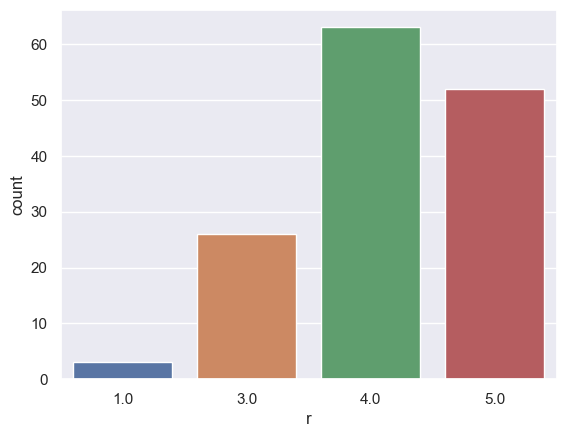

In [87]:
import seaborn as sns
kolkata['r'] = kolkata["popularity"].round()
sns.set(style="darkgrid")
ax = sns.countplot(x="r", data=kolkata)

[Text(0, 0.5, ''), Text(0.5, 0, 'Popularity Rating of the Area')]

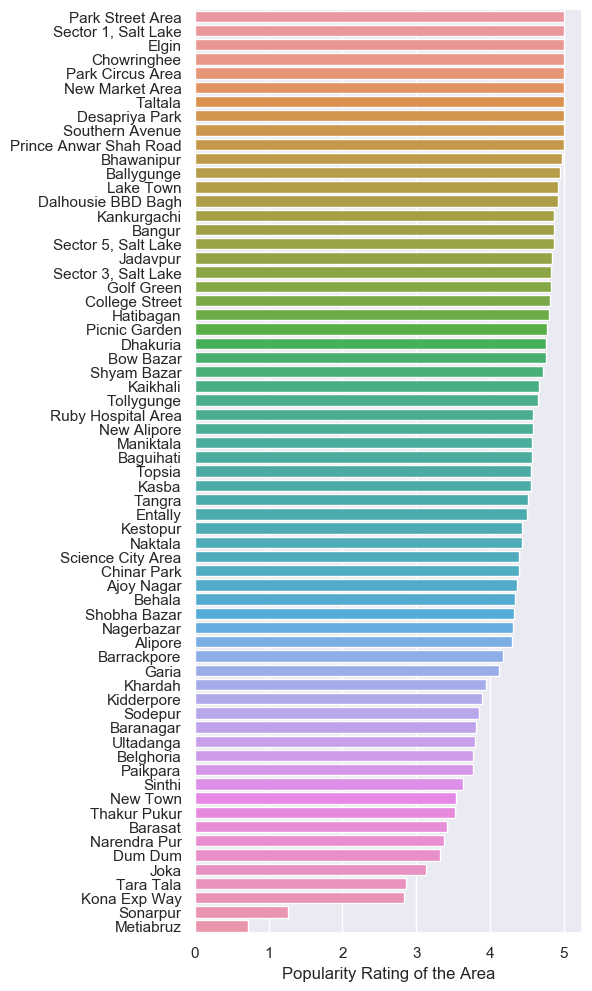

In [167]:
subzone.sort_values(by='popularity',inplace=True,ascending=False)
sns.set(rc={'figure.figsize':(5,12)})
ax = sns.barplot(x='popularity',y='subzone',data=subzone)
ax.set(xlabel='Popularity Rating of the Area', ylabel='')

[Text(0, 0.5, ''), Text(0.5, 0, 'Distanse from Kolkata city Center (Km)')]

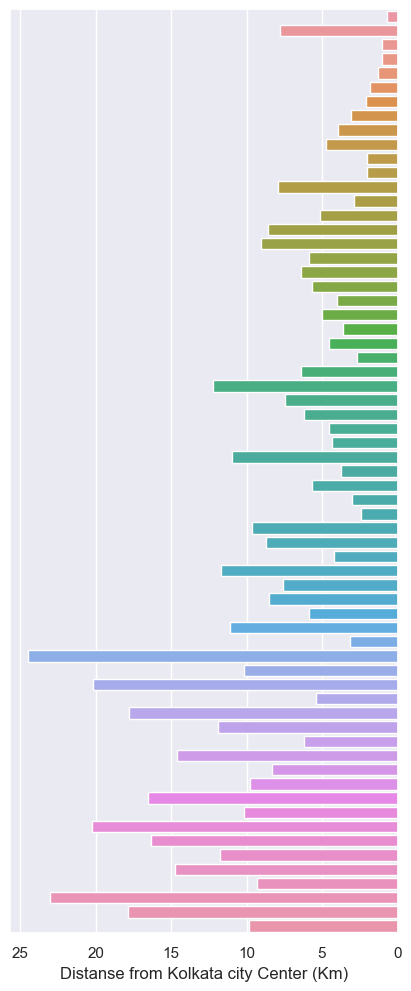

In [166]:
subzone.sort_values(by='popularity',inplace=True,ascending=False)
sns.set(rc={'figure.figsize':(5,12)})
ax = sns.barplot(x='distance',y='subzone',data=subzone)
ax.invert_xaxis()
ax.set(yticks=[])
ax.set(xlabel='Distanse from Kolkata city Center (Km)', ylabel='')


# Restaurants Datasets Analalis

In [31]:
restaurants = pd.read_csv('resturent_details.csv',index_col=0)
# Zipcode drop for nan values
restaurants.drop('zipcode',inplace=True,axis=1)
restaurants.set_index('id',inplace=True)
restaurants.head()

,name,address,locality,latitude,longitude,cuisines,average_cost_for_two,highlights,aggregate_rating,number_of_reviews
id,,,,,,,,,,
24590,Fiesta,"438, Santoshpur Avenue, Santoshpur, Kolkata",Santoshpur,22.493437,88.389166,"Chinese, Thai",700,"Dinner,Delivery,Credit Card,Lunch,Cash,Takeawa...",4.0,259
18577170,Food Junction,"167, Shreerampur Garia, Kanungo Park, Garia, K...",Garia,22.465566,88.379220,"Biryani, North Indian, Chinese",400,"Dinner,Cash,Takeaway Available,Debit Card,Lunc...",3.9,395
19206717,Rang De Basanti Dhaba,"29F, 4th Floor, Traffic More, BT Road, North B...",Sodepur,22.701523,88.374701,North Indian,800,"Takeaway Available,Debit Card,Dinner,Cash,Cred...",3.9,130
23571,Sengupta's,"1/14, Poddar Nagar, Near Girls High School, Pr...",Prince Anwar Shah Road,22.501304,88.363846,"Bengali, Biryani, North Indian, Chinese",300,"Dinner,Cash,Takeaway Available,Lunch,Delivery,...",3.5,1406
22833,Adil Biryani Centre,"38, Shamsul Huda Road, Ballygunge, Kolkata",Ballygunge,22.537167,88.370091,"Biryani, Mughlai",150,"Lunch,Cash,Takeaway Available,Dinner,Delivery,...",3.9,153


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000245D5B46DC8>]],
      dtype=object)

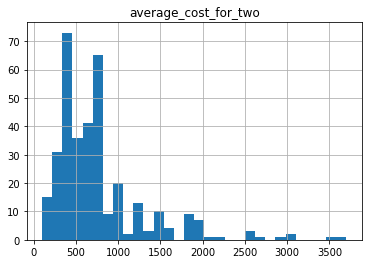

In [37]:
restaurants[['average_cost_for_two']]

In [42]:
bins = [0,300,500,1000,1500,2000,np.inf]
category = ['low','average','high','very high','expensive','very expensive']
restaurants['CostRange'] = pd.cut(restaurants['average_cost_for_two'], bins, labels=category)

In [55]:
restaurants.shape

(349, 11)

In [75]:
# one hot: coder from string to one hot codeing
cusines = restaurants['cuisines'].str.split('\s*,\s*', expand=True).stack().str.get_dummies().sum(level=0)
cusines['locality'] = restaurants['locality']
cusines= cusines.groupby('locality').mean().reset_index()
cusines

,locality,American,Asian,Awadhi,BBQ,Bakery,Bangladeshi,Bar Food,Bengali,Beverages,...,Sandwich,Seafood,South Indian,Spanish,Steak,Street Food,Sushi,Thai,Tibetan,Vietnamese
0,"Acropolis Mall, Kasba",0.250000,0.250000,0.0,0.0,0.0,0.0,0.00,0.25,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.25,0.25,0.0,0.0
1,Ajoy Nagar,0.000000,0.250000,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
2,Alipore,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,...,0.0,0.0,0.5,0.0,0.0,0.00,0.00,0.00,0.0,0.0
3,AltAir Boutique Hotel,0.000000,1.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
4,Andul Road,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,"The Pride Hotels, New Town",0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
98,"The Westin Kolkata Rajarhat, New Town",0.333333,0.666667,0.0,0.0,0.0,0.0,0.00,0.00,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
99,Tollygunge,0.000000,0.250000,0.0,0.0,0.0,0.0,0.00,0.00,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0
100,Topsia,0.000000,0.000000,0.0,0.0,0.0,0.0,0.25,0.00,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.25,0.00,0.00,0.0,0.0


In [74]:
highlights = restaurants['highlights'].str.split('\s*,\s*', expand=True).stack().str.get_dummies().sum(level=0)
highlights['locality'] = restaurants['locality']
# One Hot Coiding to frequency
highlights = highlights.groupby('locality').mean().reset_index()
highlights

,locality,4/5 Star,Above 18 Only,Air Conditioned,All Day Breakfast,Axis Bank - Dining Delights,Beer,Board Games,Breakfast,Brunch,...,Table booking not available,Table booking recommended,Table reservation required,Takeaway Available,Ticket Restaurant,Valet Parking Available,Variable Menu,Vegan Options,Wheelchair Accessible,Wifi
0,"Acropolis Mall, Kasba",0.000000,0.0,0.75,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.0,0.500000,0.0,1.000000,0.0,0.000000,0.0,0.00,0.750000,0.00
1,Ajoy Nagar,0.000000,0.0,0.75,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.0,0.250000,0.0,1.000000,0.0,0.000000,0.0,0.00,0.000000,0.00
2,Alipore,0.000000,0.0,0.50,0.000000,0.00,0.0,0.00,0.500000,0.000000,...,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.00,0.000000,0.00
3,AltAir Boutique Hotel,0.000000,0.0,1.00,0.000000,0.00,0.0,0.00,1.000000,1.000000,...,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.00
4,Andul Road,0.000000,0.0,1.00,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.00,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,"The Pride Hotels, New Town",0.000000,0.0,1.00,0.000000,0.00,0.0,0.00,1.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.00,1.000000,1.00
98,"The Westin Kolkata Rajarhat, New Town",0.666667,0.0,1.00,0.333333,0.00,0.0,0.00,0.333333,0.333333,...,0.0,0.666667,0.0,0.333333,0.0,0.666667,0.0,0.00,0.666667,0.00
99,Tollygunge,0.000000,0.0,0.75,0.000000,0.00,0.0,0.25,0.250000,0.000000,...,0.0,0.250000,0.0,1.000000,0.0,0.000000,0.0,0.25,0.000000,0.25
100,Topsia,0.000000,0.0,0.75,0.000000,0.25,0.0,0.00,0.000000,0.250000,...,0.0,0.500000,0.0,1.000000,0.0,0.500000,0.0,0.00,0.250000,0.50


In [76]:
def return_most_common_cusies_or_service(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [77]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['locality']
for ind in np.arange(num_top_venues):
    try: # try if in ['st', 'nd', 'rd'] else ['th']
        columns.append('{}{} Most Common Cusine'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Cusine'.format(ind+1))

# create a new dataframe
area_top_cusines = pd.DataFrame(columns=columns)
area_top_cusines['locality'] = cusines['locality']

for ind in np.arange(cusines.shape[0]):
    area_top_cusines.iloc[ind, 1:] = return_most_common_cusies_or_service(cusines.iloc[ind, :], num_top_venues)

area_top_cusines 

,locality,1st Most Common Cusine,2nd Most Common Cusine,3rd Most Common Cusine,4th Most Common Cusine,5th Most Common Cusine,6th Most Common Cusine,7th Most Common Cusine,8th Most Common Cusine,9th Most Common Cusine,10th Most Common Cusine
0,"Acropolis Mall, Kasba",Italian,Chinese,Bengali,Mexican,North Indian,American,Sushi,Asian,Thai,Burger
1,Ajoy Nagar,North Indian,Chinese,Mughlai,Asian,Kebab,Fast Food,Biryani,Rolls,Pizza,Cantonese
2,Alipore,Fast Food,Pizza,South Indian,Vietnamese,Cafe,Healthy Food,Goan,Finger Food,European,Desserts
3,AltAir Boutique Hotel,Italian,Asian,Finger Food,Continental,Cantonese,Ice Cream,Healthy Food,Goan,Fast Food,European
4,Andul Road,North Indian,Seafood,Chinese,Cafe,Healthy Food,Goan,Finger Food,Fast Food,European,Desserts
...,...,...,...,...,...,...,...,...,...,...,...
97,"The Pride Hotels, New Town",North Indian,Chinese,Continental,Italian,BBQ,Bakery,Ice Cream,Healthy Food,Goan,Finger Food
98,"The Westin Kolkata Rajarhat, New Town",Asian,Continental,American,Beverages,Japanese,Biryani,North Indian,Italian,Awadhi,Ice Cream
99,Tollygunge,Cafe,Beverages,Fast Food,Continental,Chinese,Pizza,Biryani,Italian,Asian,Bengali
100,Topsia,North Indian,Italian,Chinese,Mughlai,Street Food,Beverages,Continental,Biryani,Pizza,Rolls


In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['locality']
for ind in np.arange(num_top_venues):
    try: # try if in ['st', 'nd', 'rd'] else ['th']
        columns.append('{}{} Most Common Service'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Service'.format(ind+1))

# create a new dataframe
area_top_highlights = pd.DataFrame(columns=columns)
area_top_highlights['locality'] = highlights['locality']

for ind in np.arange(highlights.shape[0]):
    area_top_highlights.iloc[ind, 1:] = return_most_common_cusies_or_service(highlights.iloc[ind, :], num_top_venues)

area_top_highlights

,locality,1st Most Common Service,2nd Most Common Service,3rd Most Common Service,4th Most Common Service,5th Most Common Service,6th Most Common Service,7th Most Common Service,8th Most Common Service,9th Most Common Service,10th Most Common Service
0,"Acropolis Mall, Kasba",Credit Card,Fullbar,Indoor Seating,Takeaway Available,Dinner,Debit Card,Lunch,Cash,Mall Parking,Air Conditioned
1,Ajoy Nagar,Indoor Seating,Cash,Lunch,Dinner,Delivery,Takeaway Available,Debit Card,Credit Card,Air Conditioned,No Alcohol Available
2,Alipore,Cash,Delivery,Indoor Seating,Takeaway Available,Lunch,Dinner,Debit Card,Air Conditioned,Credit Card,Breakfast
3,AltAir Boutique Hotel,DJ,Cash,Live Sports Screening,Lunch,Fullbar,Free Wifi,Free Parking,Dinner,Outdoor Seating,Debit Card
4,Andul Road,Indoor Seating,Delivery,Air Conditioned,Takeaway Available,Dinner,Lunch,Cash,Free Wifi,Desserts and Bakes,Digital Payments Accepted
...,...,...,...,...,...,...,...,...,...,...,...
97,"The Pride Hotels, New Town",Wifi,Buffet,Wheelchair Accessible,Group Meal,Lunch,Fullbar,Dinner,Debit Card,Indoor Seating,Smoking Area
98,"The Westin Kolkata Rajarhat, New Town",Fullbar,Debit Card,Air Conditioned,Dinner,Credit Card,Lunch,Indoor Seating,Cash,Wheelchair Accessible,4/5 Star
99,Tollygunge,Lunch,Cash,Takeaway Available,Delivery,Dinner,Indoor Seating,Air Conditioned,Credit Card,Debit Card,Wifi
100,Topsia,Lunch,Takeaway Available,Indoor Seating,Cash,Dinner,DJ,Fullbar,Air Conditioned,Debit Card,Delivery
